**Ben KABONGO**, *21116436*, M1 DAC

# Data mining \& clustering

The goal if this practical is to adress the folowing problem: 
<center style="color:red" >  Given XXX raw, unlabeled documents, ... How to exploit/understand/represent them?</center>

In the previous week, we have seen how to represent textual data with the Bag of Words (BoW) model:
$$X = 
	\begin{matrix} 
	 & \textbf{t}_j \\
	 & \downarrow \\
	\textbf{d}_i \rightarrow &
	\begin{pmatrix} 
	x_{1,1} & \dots & x_{1,d} \\
	\vdots & \ddots & \vdots \\
	x_{N,1} & \dots & x_{N,d} \\
	\end{pmatrix}
	\end{matrix}
	$$

From this BoW representation, we want to answer the following questions:
1. Which clustering algorithm to choose?
    - K-means, LSA, pLSA, LDA
1. What results to expect?
    - Semantics, noise cleaning, etc...
1. Which qualitative and quantitative analyses to understand the groups?
[comment]: <> (%1. Comment boucler, itérer pour améliorer la qualité du processus?)


<span style="color:magenta" > In this practical, we use a **labeled dataset** in order to evaluate performances with quantitative and well-defined metrics. </span>


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import codecs
import collections
import re
import os.path
import sklearn
import nltk

from wordcloud import WordCloud

## Data loading



In [2]:
from sklearn.datasets import fetch_20newsgroups
newsgroups_train = fetch_20newsgroups(subset='train')

In [3]:
# conversion BoW + tf-idf
from sklearn.feature_extraction.text import TfidfVectorizer
#vectorizer = TfidfVectorizer() 
vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=1000, stop_words='english')

vectors = vectorizer.fit_transform(newsgroups_train.data)
print(vectors.shape)

# sparsity measure = 44 active words over 1000 per document (157 over 130000) !!
print(vectors.nnz / float(vectors.shape[0]))

(11314, 1000)
44.164928407283014


In [4]:
# retrieve words
print([(i,vectorizer.get_feature_names_out()[i]) \
       for i in np.random.randint(vectors.shape[1], size=10)])

[(523, 'kill'), (569, 'love'), (109, 'anybody'), (485, 'included'), (91, 'advance'), (383, 'federal'), (916, 'trying'), (860, 'steve'), (479, 'ii'), (724, 'product')]


In [5]:
# labels (only for evaluation)
Y = newsgroups_train.target
print(Y[:10]) 
print([newsgroups_train.target_names[i] for i in Y[:20]]) # vraie classe

[ 7  4  4  1 14 16 13  3  2  4]
['rec.autos', 'comp.sys.mac.hardware', 'comp.sys.mac.hardware', 'comp.graphics', 'sci.space', 'talk.politics.guns', 'sci.med', 'comp.sys.ibm.pc.hardware', 'comp.os.ms-windows.misc', 'comp.sys.mac.hardware', 'rec.motorcycles', 'talk.religion.misc', 'comp.sys.mac.hardware', 'sci.space', 'misc.forsale', 'alt.atheism', 'comp.graphics', 'rec.autos', 'sci.electronics', 'comp.windows.x']


# 0) Word clouds 
### Drawing word clouds from the raw corpus or words' frequencies :  [make word clouds !](https://github.com/amueller/word_cloud)

### Installation
If you are using pip:

`pip install wordcloud`

### If you are using conda, you can install from the conda-forge channel:

`conda install -c conda-forge wordcloud`

### Let's look at the most frequent words in this dataset

In [6]:
data = np.array(newsgroups_train.data)
corpus = "".join(data)
words = corpus.split() # optional args to choose the splitting chars
print("Nb mots=",len(words))

Nb mots= 3252437


In [7]:
punctuation = r"[\!\"\#\$\%\&\'\(\)\*\+\,\-\.\/\:\;\<\=\>\?\@\[\\\]\^\_\`\{\|\}\~\n\t]"
corpus_punc = re.sub(punctuation, " ", corpus)
corpus_punc = re.sub('( )+', ' ', corpus_punc).lower()
corpus_punc[:1000]

'from lerxst wam umd edu where s my thing subject what car is this nntp posting host rac3 wam umd edu organization university of maryland college park lines 15 i was wondering if anyone out there could enlighten me on this car i saw the other day it was a 2 door sports car looked to be from the late 60s early 70s it was called a bricklin the doors were really small in addition the front bumper was separate from the rest of the body this is all i know if anyone can tellme a model name engine specs years of production where this car is made history or whatever info you have on this funky looking car please e mail thanks il brought to you by your neighborhood lerxst from guykuo carson u washington edu guy kuo subject si clock poll final call summary final call for si clock reports keywords si acceleration clock upgrade article i d shelley 1qvfo9innc3s organization university of washington lines 11 nntp posting host carson u washington edu a fair number of brave souls who upgraded their si

In [8]:
words = corpus_punc.split()
words_counter = collections.Counter(words)
top_100_words = words_counter.most_common(100)
top_100_words

[('the', 146691),
 ('to', 75073),
 ('of', 69049),
 ('a', 64298),
 ('ax', 62412),
 ('and', 57964),
 ('i', 53128),
 ('in', 49414),
 ('is', 43510),
 ('that', 39273),
 ('it', 33638),
 ('for', 28606),
 ('you', 26692),
 ('from', 22673),
 ('s', 22575),
 ('edu', 21321),
 ('on', 20500),
 ('this', 20123),
 ('be', 19287),
 ('t', 18822),
 ('are', 18629),
 ('not', 18547),
 ('have', 18076),
 ('with', 17333),
 ('as', 15834),
 ('1', 15322),
 ('or', 14689),
 ('was', 13661),
 ('if', 13646),
 ('but', 13429),
 ('they', 13216),
 ('m', 13058),
 ('subject', 12265),
 ('com', 12134),
 ('lines', 11835),
 ('can', 11360),
 ('at', 11332),
 ('organization', 11233),
 ('by', 11170),
 ('re', 10533),
 ('2', 10414),
 ('an', 10110),
 ('what', 9865),
 ('my', 9738),
 ('there', 9690),
 ('3', 9638),
 ('x', 9605),
 ('0', 9536),
 ('all', 9326),
 ('will', 9291),
 ('we', 9232),
 ('one', 9017),
 ('would', 8910),
 ('do', 8686),
 ('he', 8445),
 ('about', 8336),
 ('writes', 7844),
 ('so', 7765),
 ('your', 7644),
 ('no', 7611),
 ('ha

### Plot the N frequent words and verify that its follows a Zipf law

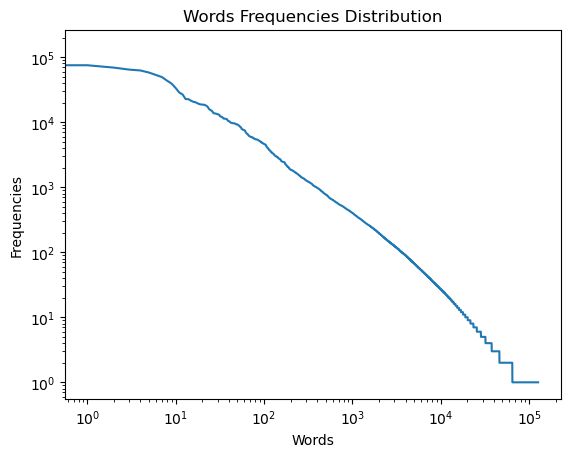

In [9]:
dic = dict(words_counter)
keys = list(dic.keys())
values = np.array(list(dic.values()))
sort = -np.sort(-values)
argsort = np.argsort(-values)

# print(keys[argsort[0]]) == the

# plot
plt.title('Words Frequencies Distribution')
plt.loglog(np.arange(len(keys)), sort)
plt.xlabel('Words')
plt.ylabel('Frequencies')
plt.show()

`La distribution des fréquences des mots semble bel et bien suivre la loi de Zipf`

### Experiment word clouds

(-0.5, 399.5, 199.5, -0.5)

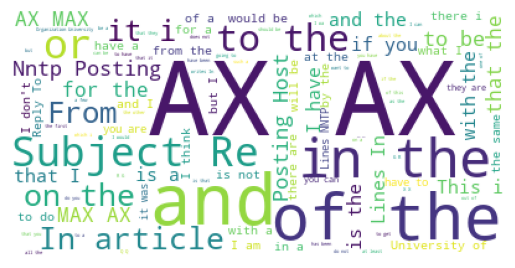

In [10]:
wordcloud = WordCloud(background_color='white', stopwords = [], max_words=100).generate(corpus)            

plt.figure()
plt.imshow(wordcloud)
plt.axis('off')

(-0.5, 399.5, 199.5, -0.5)

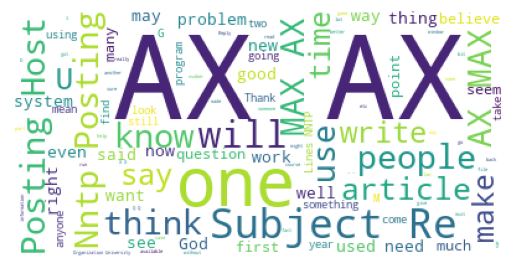

In [11]:
from wordcloud import STOPWORDS # Note: this is the default option           
wordcloud = WordCloud(background_color='white', stopwords = STOPWORDS, max_words=100).generate(corpus) 

plt.figure()
plt.imshow(wordcloud)
plt.axis("off")

### Use word clouds with generate\_from\_frequencies. 
N.B.: retrieve the most words frequencies using a CountVectorizer

In [12]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer()
X = cv.fit_transform(data)

In [13]:
sum0 = X.sum(0)
words_freq = [(word, sum0[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
words_freq = dict(words_freq)

(-0.5, 399.5, 199.5, -0.5)

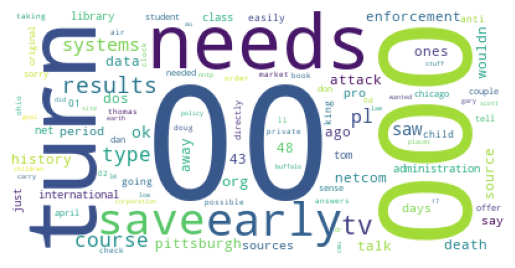

In [14]:
wordcloud = WordCloud(
    background_color='white', 
    stopwords = STOPWORDS, 
    max_words=100).generate_from_frequencies(words_freq) 

plt.figure()
plt.imshow(wordcloud)
plt.axis("off")

### Drawing word clouds from classes


In [15]:
def word_cloud_from_classes(Y):
    for y in np.unique(Y):
        idx = np.where(Y == y)[0]
        corpus_y = ' '.join(data[idx])
        corpus_y = re.sub('( )+', ' ', re.sub(punctuation, " ", corpus_y))

        wordcloud = WordCloud(background_color='white', stopwords = STOPWORDS, max_words=100).generate(corpus_y) 

        plt.figure()
        plt.title(y)
        plt.imshow(wordcloud)
        plt.axis("off")

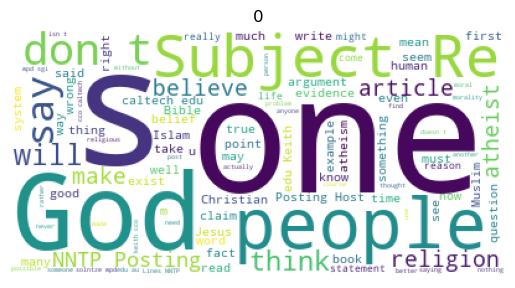

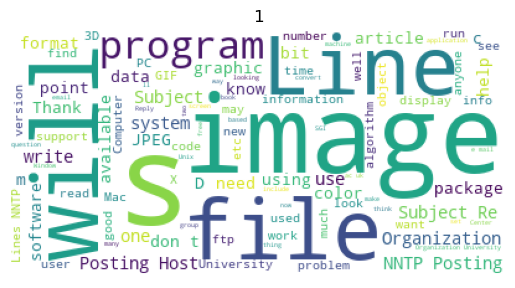

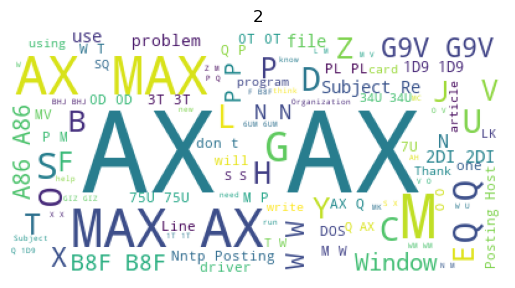

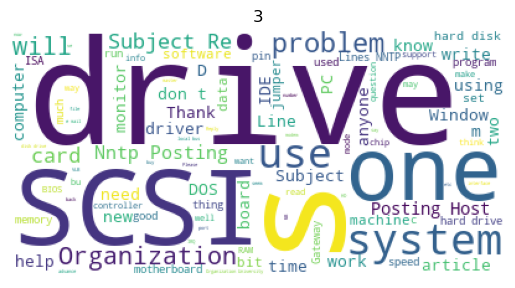

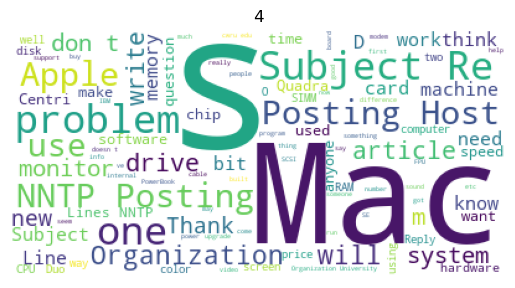

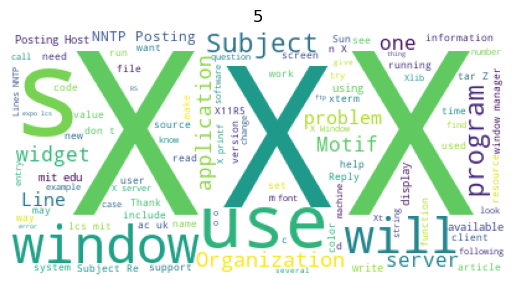

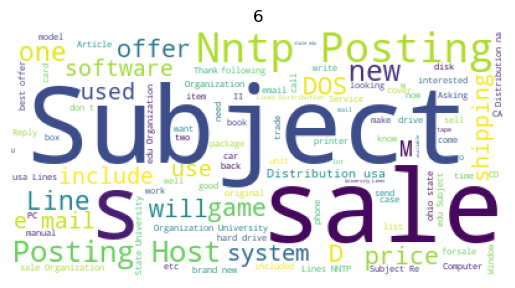

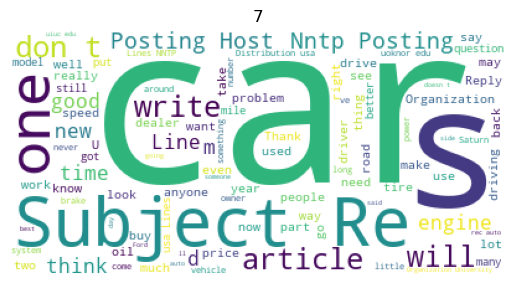

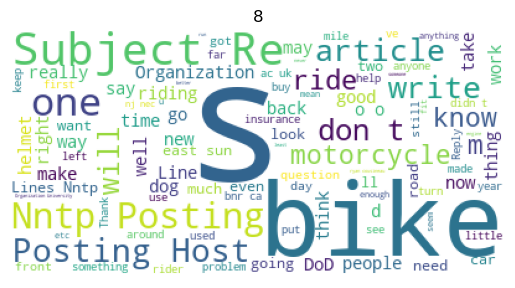

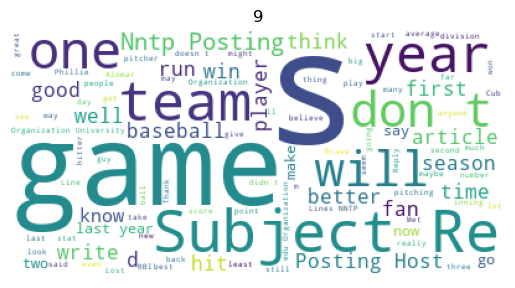

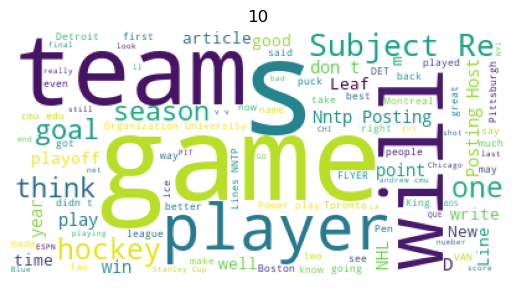

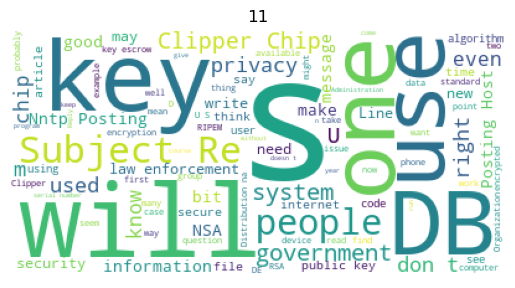

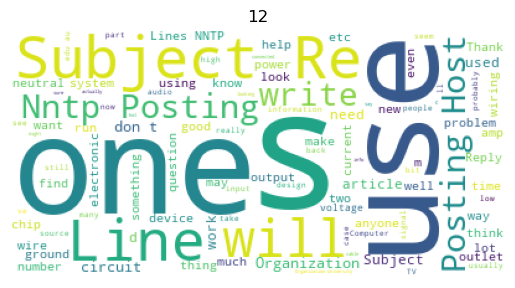

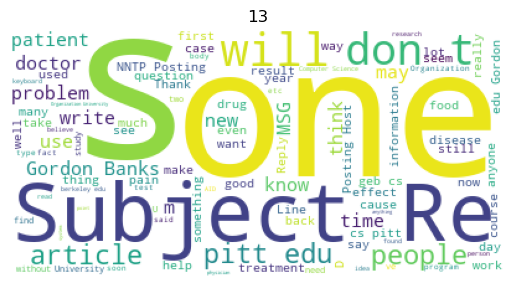

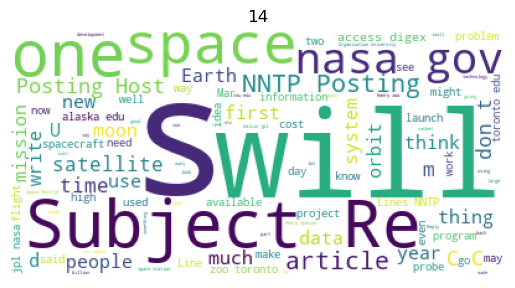

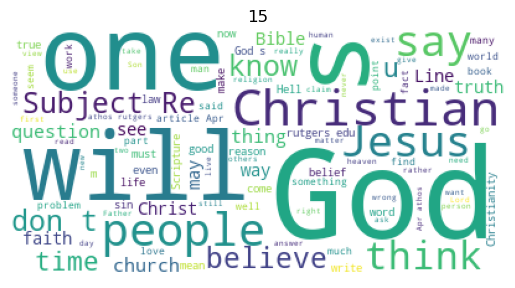

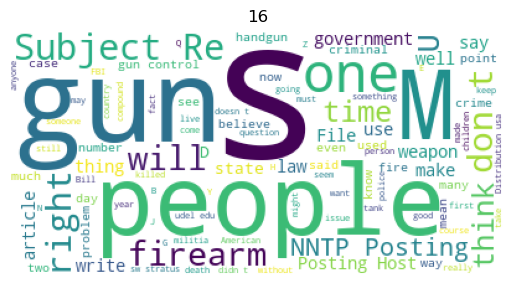

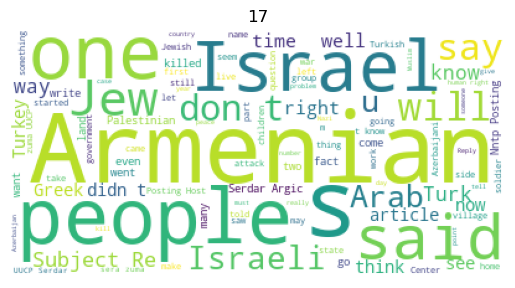

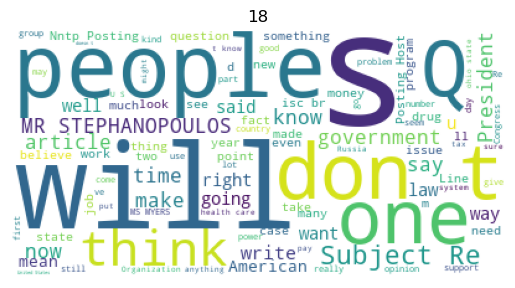

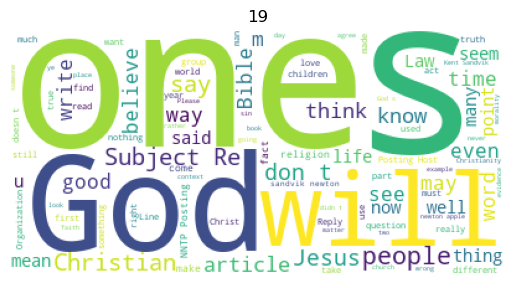

In [16]:
word_cloud_from_classes(Y)

# 1) Clustering algorithm: K-Means

**Let's start by the most famous and simple unsupervised algorithm: $k$-means!**
Look at [sklear documentation](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)
and apply it to your BoW matrix.


In [17]:
from sklearn.cluster import KMeans
# your code here
kmeans = KMeans(n_clusters=20, random_state=0, max_iter=10).fit(vectors)
# Getting clusters:
kmeans.cluster_centers_

array([[0.00481251, 0.00431009, 0.00048919, ..., 0.00481887, 0.01265084,
        0.00097928],
       [0.00369518, 0.01008388, 0.00139004, ..., 0.01172087, 0.00496925,
        0.00488701],
       [0.00390038, 0.00431445, 0.0023992 , ..., 0.00616613, 0.00405261,
        0.00336554],
       ...,
       [0.00050777, 0.00514748, 0.00089056, ..., 0.00369742, 0.00111354,
        0.        ],
       [0.00836867, 0.0035352 , 0.        , ..., 0.00816881, 0.0031431 ,
        0.01436739],
       [0.0015631 , 0.00515836, 0.00593669, ..., 0.00522794, 0.00822491,
        0.00154939]])

In [18]:
vectors.shape, kmeans.cluster_centers_.shape

((11314, 1000), (20, 1000))

### Clustering Analysis: 
1. **Qualtitative:**
    - Look at the most important words for each cluster
    - Perform cluster assignement to each document, and compute word cloud on the document (raw text or frequencies)
2. **Quantitative:**
    - Compute cluster "purity": $p_j= \frac{|y^*|}{|C_j|}$, where $y^*$ is the most frequent (GT) label in cluster $C$ $\Rightarrow$ $p = \sum\limits_j |C_j| p_j$
    - Compute [Rand Score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.rand_score.html) and [Adjusted Rand Score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html#sklearn.metrics.adjusted_rand_score) 

In [19]:
# Look at the most important words for each cluster
most_important_word_index = np.abs(kmeans.cluster_centers_).argmax(1)
most_important_word_index

array([202, 679, 241, 622, 193, 409, 519, 977, 687, 923, 505, 976, 346,
       336, 787, 185, 427, 285, 104, 924])

In [20]:
for cl, i in enumerate(most_important_word_index):
    print(cl, ':', vectorizer.get_feature_names_out()[i])

0 : cc
1 : people
2 : com
3 : nasa
4 : card
5 : game
6 : key
7 : windows
8 : pitt
9 : uiuc
10 : israel
11 : window
12 : edu
13 : drive
14 : sale
15 : ca
16 : god
17 : cwru
18 : andrew
19 : uk


In [21]:
# Perform cluster assignement to each document, and compute word cloud on the document (raw text or frequencies)
Y_pred = kmeans.predict(vectors)
print(Y_pred[:10])
print(np.unique(Y_pred))

[12 12  1  2 12  2 12 13 14  4]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


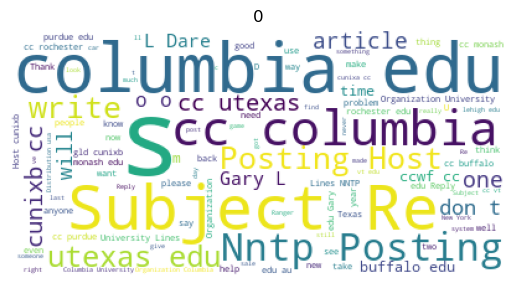

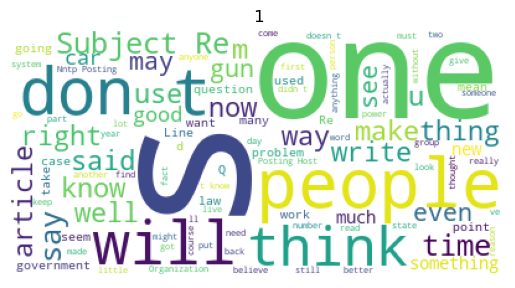

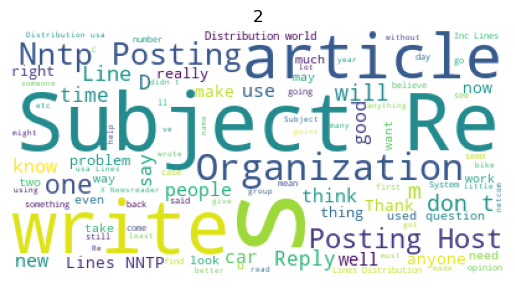

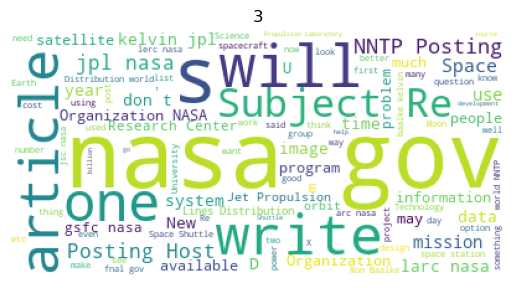

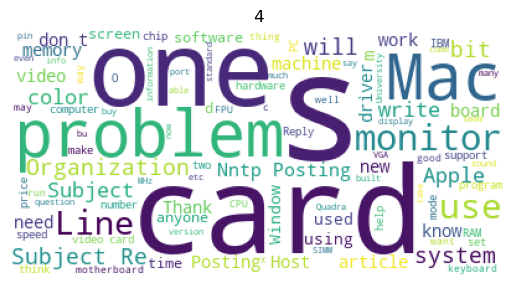

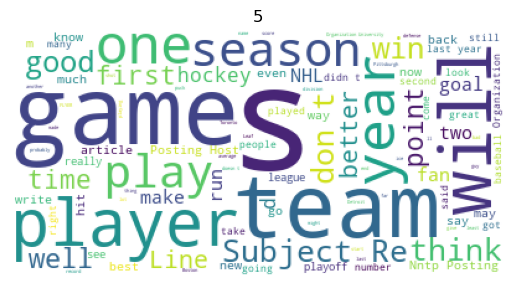

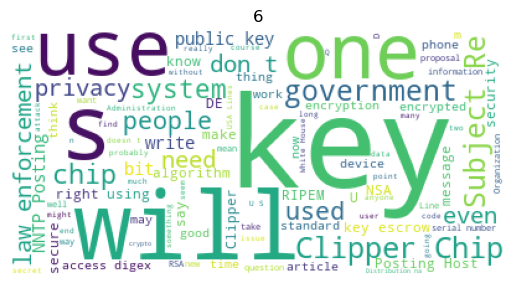

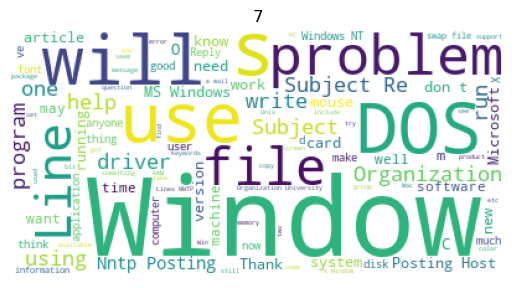

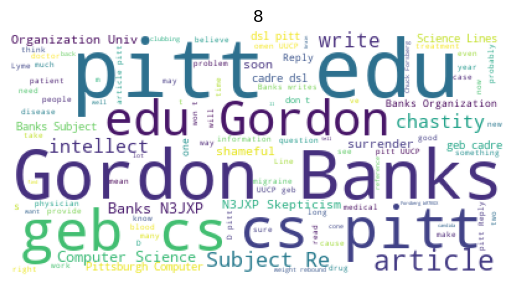

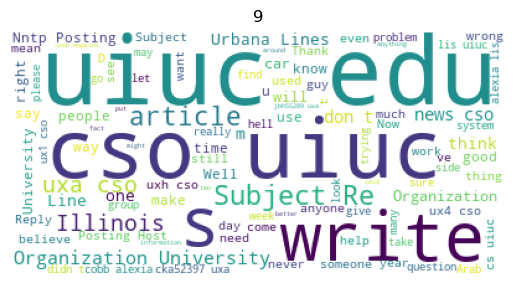

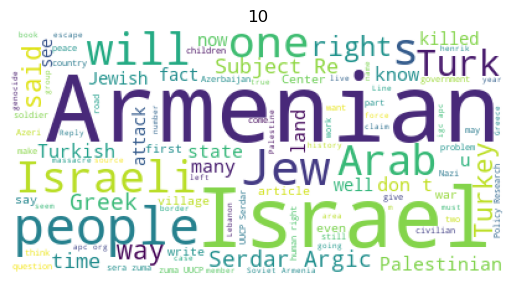

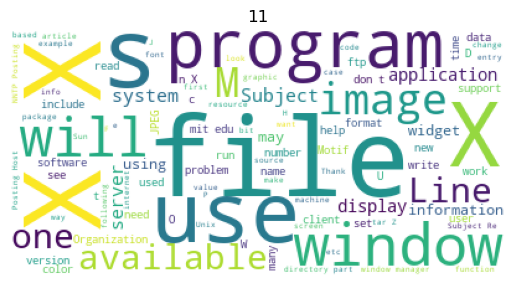

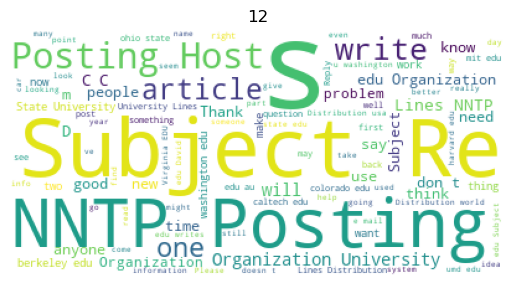

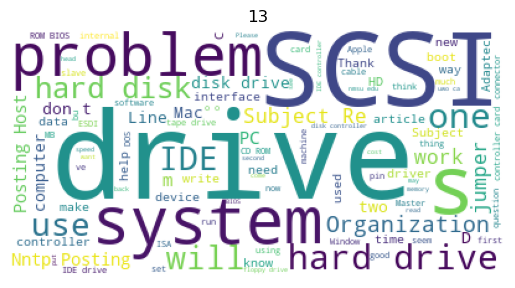

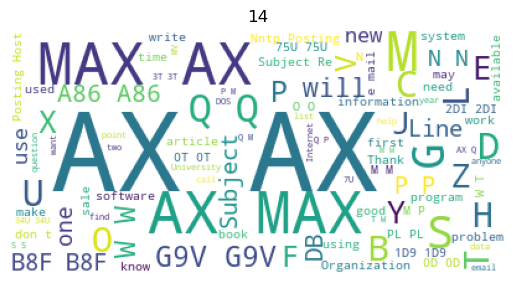

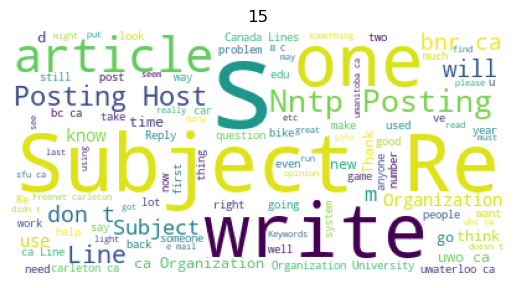

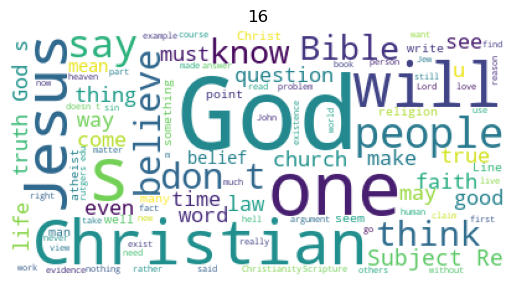

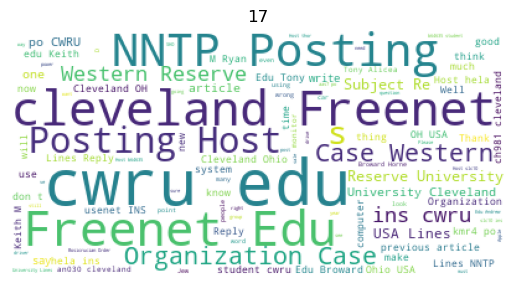

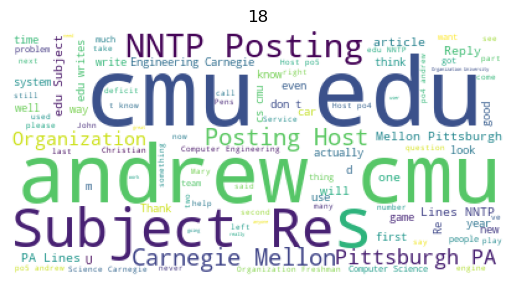

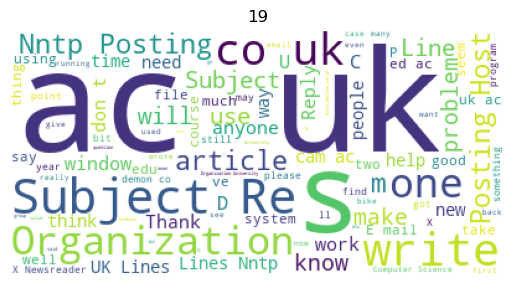

In [22]:
# compute word cloud on the document (raw text or frequencies)
word_cloud_from_classes(Y_pred)

In [23]:
# Compute cluster "purity":
purity = 0
for y in np.unique(Y_pred):
    idx = np.where(Y_pred == y)[0]
    res = Y[idx]
    uy, cy = np.unique(res, return_counts=True)
    purity += np.max(cy)
purity /= len(Y_pred)
purity

0.3102351069471451

In [24]:
# Compute Rand Score and Adjusted Rand Score
from sklearn.metrics import rand_score
rand_score(Y_pred, Y)

0.8852879124091465

In [25]:
from sklearn.metrics.cluster import adjusted_rand_score
adjusted_rand_score(Y_pred, Y)

0.11120721708814237

# 2) Latent Semantic Analysis (LSA <=> SVD) 


**Remember the LSA factorziation**: 
$$ 
\begin{matrix} 
 & X  &\!\!\!\!\!=\!\!\!\!\!& U  & \Sigma & V^T \\
  & \textbf{t}_j   &  & \hat{ \textbf{d}_i} & &  \\
 & \downarrow  &  &\downarrow  & & \\
\textbf{d}_i \rightarrow 
&
\begin{pmatrix} 
x_{1,1} & \dots & x_{1,d} \\
\\
\vdots & \ddots & \vdots \\
\\
x_{N,1} & \dots & x_{N,d} \\
\end{pmatrix}
&
\!\!\!\!\!=\!\!\!\!\!
%&
%(\hat{ \textbf{t}_j}) \rightarrow
&
\begin{pmatrix} 
\begin{pmatrix} &  \textbf{u}_1 &  \end{pmatrix} \\
\vdots \\
\begin{pmatrix}  & \textbf{u}_k &  \end{pmatrix}
\end{pmatrix}
%&
%\!\!\!\!\!\cdot\!\!\!\!\!
&
\begin{pmatrix} 
\sigma_1 & \dots & 0 \\
\vdots & \ddots & \vdots \\
0 & \dots & \sigma_k \\
\end{pmatrix}
%&
%\!\!\!\!\!\cdot\!\!\!\!\!
&
\begin{pmatrix} 
\begin{pmatrix} \, \\ \, \\ \textbf{v}_1 \\ \, \\ \,\end{pmatrix} 
\dots
\begin{pmatrix} \, \\ \, \\ \textbf{v}_k \\ \, \\ \, \end{pmatrix}
\end{pmatrix}
\end{matrix}
$$

- Look at [SVD doc in skelarn](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html#sklearn.decomposition.TruncatedSVD)
- Do the same qualitative/quantitative evaluation than with K-Means
- You can also use LSA as a pre-processing step for K-Means, *i.e.* running K-Means on $\boldsymbol{U}$ matrix above
    - N.B. : try without/with $\ell_2$ normalization of $\boldsymbol{U}$'s rows before running  K-Means
    - You can also benefit from LSA pre-processing for using [t-SNE visualization](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) (see code below)


In [26]:
# t-SNE from the U matrix computed by LSA
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD

lsa = TruncatedSVD(n_components=50)
U = lsa.fit_transform(vectors)

tsne = TSNE(n_components=2, init='pca',n_iter=5000, verbose=2)
tsne_mat = tsne.fit_transform(U)

/Users/benkabongo25/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 11314 samples in 0.000s...
[t-SNE] Computed neighbors for 11314 samples in 0.456s...
[t-SNE] Computed conditional probabilities for sample 1000 / 11314
[t-SNE] Computed conditional probabilities for sample 2000 / 11314
[t-SNE] Computed conditional probabilities for sample 3000 / 11314
[t-SNE] Computed conditional probabilities for sample 4000 / 11314
[t-SNE] Computed conditional probabilities for sample 5000 / 11314
[t-SNE] Computed conditional probabilities for sample 6000 / 11314
[t-SNE] Computed conditional probabilities for sample 7000 / 11314
[t-SNE] Computed conditional probabilities for sample 8000 / 11314
[t-SNE] Computed conditional probabilities for sample 9000 / 11314
[t-SNE] Computed conditional probabilities for sample 10000 / 11314
[t-SNE] Computed conditional probabilities for sample 11000 / 11314
[t-SNE] Computed conditional probabilities for sample 11314 / 11314
[t-SNE] Mean sigma: 0.115923
[t-SNE] Computed cond

/Users/benkabongo25/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] Iteration 50: error = 93.1508408, gradient norm = 0.0005605 (50 iterations in 1.446s)
[t-SNE] Iteration 100: error = 93.0220947, gradient norm = 0.0002715 (50 iterations in 1.373s)
[t-SNE] Iteration 150: error = 92.9982986, gradient norm = 0.0001905 (50 iterations in 1.394s)
[t-SNE] Iteration 200: error = 92.9878998, gradient norm = 0.0001678 (50 iterations in 1.319s)
[t-SNE] Iteration 250: error = 92.9796295, gradient norm = 0.0002103 (50 iterations in 1.333s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 92.979630
[t-SNE] Iteration 300: error = 3.2171154, gradient norm = 0.0013322 (50 iterations in 1.261s)
[t-SNE] Iteration 350: error = 2.6751466, gradient norm = 0.0005840 (50 iterations in 1.186s)
[t-SNE] Iteration 400: error = 2.4300730, gradient norm = 0.0003441 (50 iterations in 1.183s)
[t-SNE] Iteration 450: error = 2.2861731, gradient norm = 0.0002371 (50 iterations in 1.216s)
[t-SNE] Iteration 500: error = 2.1898642, gradient norm = 0.0001770 (50 

[t-SNE] Iteration 4350: error = 1.8272927, gradient norm = 0.0000228 (50 iterations in 1.482s)
[t-SNE] Iteration 4400: error = 1.8269589, gradient norm = 0.0000248 (50 iterations in 1.496s)
[t-SNE] Iteration 4450: error = 1.8266203, gradient norm = 0.0000245 (50 iterations in 1.427s)
[t-SNE] Iteration 4500: error = 1.8262880, gradient norm = 0.0000251 (50 iterations in 1.356s)
[t-SNE] Iteration 4550: error = 1.8258829, gradient norm = 0.0000239 (50 iterations in 1.354s)
[t-SNE] Iteration 4600: error = 1.8255740, gradient norm = 0.0000257 (50 iterations in 1.359s)
[t-SNE] Iteration 4650: error = 1.8252884, gradient norm = 0.0000252 (50 iterations in 1.384s)
[t-SNE] Iteration 4700: error = 1.8249468, gradient norm = 0.0000261 (50 iterations in 1.371s)
[t-SNE] Iteration 4750: error = 1.8247093, gradient norm = 0.0000227 (50 iterations in 1.344s)
[t-SNE] Iteration 4800: error = 1.8244759, gradient norm = 0.0000211 (50 iterations in 1.361s)
[t-SNE] Iteration 4850: error = 1.8241706, gradien

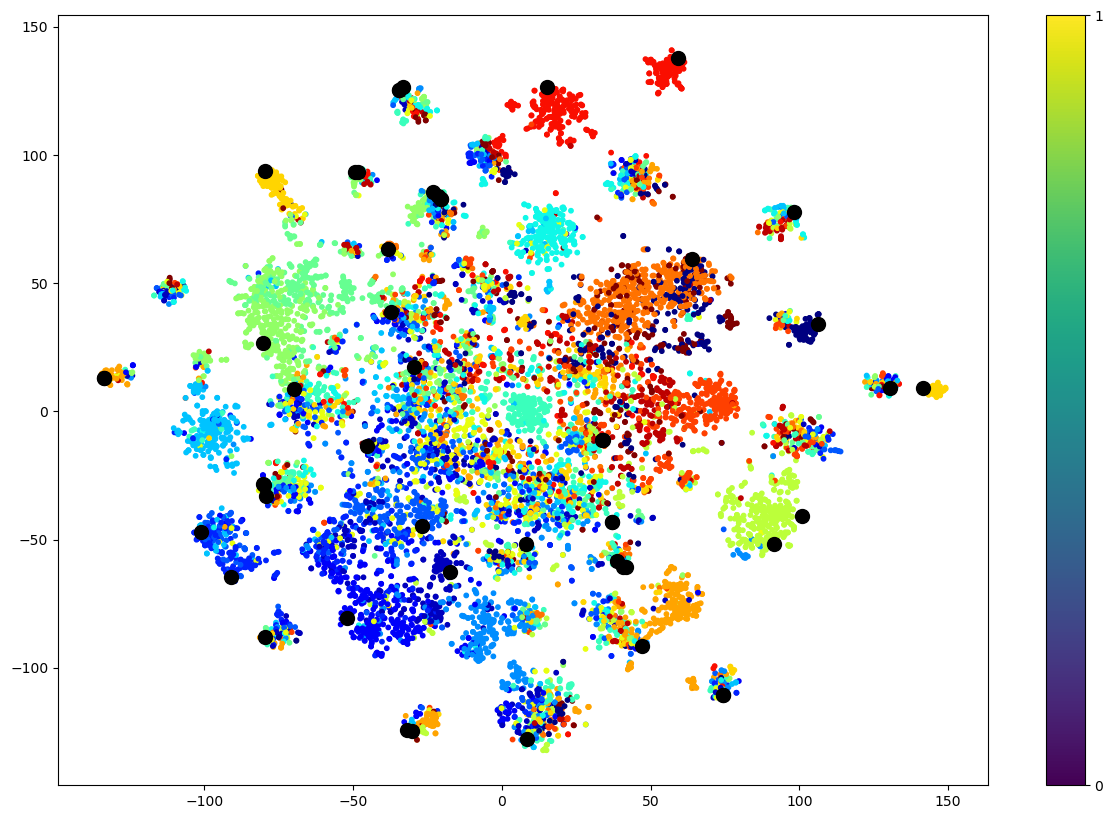

In [27]:
NN2cluster = np.argmax(np.abs(U), axis=0)
import seaborn as sns
import matplotlib.cm as cm
cmap = cm.tab20
cmap = cm.get_cmap('hsv', 20) 
cmap = cm.get_cmap('jet', 20)
#cmap = cm.tab20

plt.figure(figsize=(15,10))
plt.scatter(tsne_mat[:,0],tsne_mat[:,1], c=Y, cmap=cmap, s=10)
plt.scatter(tsne_mat[NN2cluster[:],0],tsne_mat[NN2cluster[:],1], c='black', s=100)
#plt.scatter(tsne_mat[NN2cluster2[:],0],tsne_mat[NN2cluster2[:],1], c='red', s=100)
plt.colorbar(ticks=range(20))

# 3) Latent Dirichlet Allocation (LDA)

Perform the same experiments with LDA:
- LDA
https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html


**Start with a CountVectorizer**

In [28]:
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import CountVectorizer

# Initialize regex tokenizer
tokenizer = RegexpTokenizer(r'\w+')

# Vectorize document using TF-IDF
vectorizer = CountVectorizer(lowercase=True,
                        stop_words='english',
                        ngram_range = (1,1),
                        tokenizer = tokenizer.tokenize, max_df=0.95, min_df=2, max_features=1000)

vectors = vectorizer.fit_transform(newsgroups_train.data)
print(vectors.shape)
print(vectors.nnz / float(vectors.shape[0]))



(11314, 1000)
48.02527841612162


## LDA-viz

In [29]:
# pip install pyldavis
from __future__ import print_function
from sklearn.decomposition import LatentDirichletAllocation

import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

lda = LatentDirichletAllocation(n_components=2, random_state=0)
lda.fit(vectors)

pyLDAvis.sklearn.prepare(lda,vectors,vectorizer)

/Users/benkabongo25/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/benkabongo25/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Users/benkabongo25/opt/anaconda3/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
/Users/benkabongo25/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's docum

PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
0      0.260066  0.0       1        1  79.099525
1     -0.260066  0.0       2        1  20.900475, topic_info=    Term          Freq         Total Category  logprob  loglift
146   ax  64521.000000  64521.000000  Default  30.0000  30.0000
570    m  13008.000000  13008.000000  Default  29.0000  29.0000
0      0   9650.000000   9650.000000  Default  28.0000  28.0000
732    q   6503.000000   6503.000000  Default  27.0000  27.0000
41     3   9741.000000   9741.000000  Default  26.0000  26.0000
..   ...           ...           ...      ...      ...      ...
54     4   2890.425635   6138.805760   Topic2  -4.3601   0.8122
188    c   2395.869122   4827.622946   Topic2  -4.5477   0.8648
782    s   3036.070639  22246.703124   Topic2  -4.3109  -0.4262
992    x   2568.003818   9350.505605   Topic2  -4.4783   0.2731
871    t   2634.741727  18657.876519   Topic2  -4.4527  -0.3921

[155 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
0         1  0.300809     0
0         2  0.699229     0
7         2  0.999733    0d
8         2  0.998569    0t
9         1  0.618619     1
...     ...       ...   ...
993       2  0.907975     y
994       1  0.999502  year
994       2  0.000491  year
999       1  0.084059     z
999       2  0.916022     z

[220 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2])

# Performances evaluation

**Compare the different approaches wrt three quantitative metrics.**

### LSA

In [30]:
kmeans_lsa = KMeans(n_clusters=20, random_state=0, max_iter=10).fit(U)
kmeans_lsa.cluster_centers_

array([[ 2.42660846e-01, -3.13822469e-02, -7.89272278e-03,
         2.94052647e-02,  3.99199575e-02, -4.79548300e-03,
        -5.61130613e-02, -1.95759061e-03, -6.50050132e-02,
        -7.21351151e-02, -7.70643527e-02,  6.35926337e-03,
        -6.49868830e-02,  2.89895812e-02, -1.06145049e-01,
        -5.81505228e-02,  5.69348178e-02,  1.00933118e-01,
         2.93536892e-03,  4.17182943e-03, -2.67121234e-02,
         6.81310557e-02, -3.33887806e-02,  2.00858705e-02,
         4.04602857e-02,  2.03476086e-02, -3.00334740e-02,
         5.27214513e-02,  5.50476784e-02,  4.51250677e-03,
        -5.79447219e-02, -1.44171013e-02, -8.49426549e-02,
         5.20614313e-02,  1.23990107e-02, -6.33219227e-02,
         3.28434400e-02, -2.98953021e-02, -7.36033396e-03,
         2.96332867e-02,  2.72509845e-02, -2.14930558e-02,
         9.80945566e-03, -6.61611321e-03, -2.25889019e-02,
        -1.63240039e-02, -4.18173517e-03,  2.40813755e-03,
         6.91924215e-04,  2.30282979e-02],
       [ 2.18

In [31]:
kmeans_lsa.cluster_centers_.shape

(20, 50)

In [32]:
# Perform cluster assignement to each document, and compute word cloud on the document (raw text or frequencies)
Y_pred = kmeans_lsa.predict(U)
print(Y_pred[:10])
print(np.unique(Y_pred))

[ 0 13 12  9 13 18 13 10 12 12]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


In [33]:
# Compute cluster "purity":
purity = 0
for y in np.unique(Y_pred):
    idx = np.where(Y_pred == y)[0]
    res = Y[idx]
    uy, cy = np.unique(res, return_counts=True)
    purity += np.max(cy)
purity /= len(Y_pred)
purity

0.31138412586176417

In [34]:
rand_score(Y_pred, Y)

0.8747434924984188

In [35]:
adjusted_rand_score(Y_pred, Y)

0.101542848995341